# Introduction to Statistical Inference

In this session we introduce statistical inference. Statistical inference consists in assuming a probabilistic model as the generating process of real-world observations. Based on those observations, we infer some parameters of the probabilistic model. This allows us to make predictions for new observations.

Let us first look at an example. We consider flight delay data. In terms of applications, we might want to propose flight delay insurance. This would require to determine the probability distribution of delays. 
Let's take a look at a dataset of flight delays in the USA.

In [4]:
files

[PosixPath('/home/arthur/.cache/kagglehub/datasets/usdot/flight-delays/versions/1/flights.csv'),
 PosixPath('/home/arthur/.cache/kagglehub/datasets/usdot/flight-delays/versions/1/airports.csv'),
 PosixPath('/home/arthur/.cache/kagglehub/datasets/usdot/flight-delays/versions/1/airlines.csv')]

In [5]:
import pandas as pd
from pathlib import Path

import kagglehub

# Download latest version
path = kagglehub.dataset_download("usdot/flight-delays")

path = Path(path)
files = list(path.iterdir())

data = pd.read_csv(path / 'flights.csv', nrows=10000)
data

,YEAR,MONTH,DAY,DAY_OF_WEEK,AIRLINE,FLIGHT_NUMBER,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,...,ARRIVAL_TIME,ARRIVAL_DELAY,DIVERTED,CANCELLED,CANCELLATION_REASON,AIR_SYSTEM_DELAY,SECURITY_DELAY,AIRLINE_DELAY,LATE_AIRCRAFT_DELAY,WEATHER_DELAY
0,2015,1,1,4,AS,98,N407AS,ANC,SEA,5,...,408.0,-22.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
1,2015,1,1,4,AA,2336,N3KUAA,LAX,PBI,10,...,741.0,-9.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
2,2015,1,1,4,US,840,N171US,SFO,CLT,20,...,811.0,5.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
3,2015,1,1,4,AA,258,N3HYAA,LAX,MIA,20,...,756.0,-9.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,2015,1,1,4,AS,135,N527AS,SEA,ANC,25,...,259.0,-21.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,2015,1,1,4,HA,165,N492HA,OGG,HNL,1705,...,1757.0,17.0,0,0,NaN,0.0,0.0,7.0,10.0,0.0
9996,2015,1,1,4,MQ,3046,N610MQ,DBQ,ORD,1705,...,1743.0,-32.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
9997,2015,1,1,4,MQ,3048,N679MQ,ORD,CMI,1705,...,1814.0,26.0,0,0,NaN,10.0,0.0,5.0,11.0,0.0
9998,2015,1,1,4,MQ,3118,N512MQ,MDT,ORD,1705,...,2131.0,196.0,0,0,NaN,21.0,0.0,112.0,63.0,0.0


In particular, we are interested in a specific column: ARRIVAL_DELAY. 

In [2]:
subdata = data[['MONTH', 'DAY_OF_WEEK', 'ORIGIN_AIRPORT', 'DESTINATION_AIRPORT', 'ARRIVAL_DELAY']][(data.ARRIVAL_DELAY > 0) & (data.ARRIVAL_DELAY < 120)]
subdata[:20]

,MONTH,DAY_OF_WEEK,ORIGIN_AIRPORT,DESTINATION_AIRPORT,ARRIVAL_DELAY
2,1,4,SFO,CLT,5.0
5,1,4,SFO,MSP,8.0
14,1,4,SEA,MSP,8.0
20,1,4,LAS,MCI,6.0
21,1,4,SEA,MIA,1.0
27,1,4,MSP,FLL,25.0
29,1,4,DEN,MIA,2.0
30,1,4,PHX,ORD,43.0
33,1,4,SLC,ATL,10.0
35,1,4,LAS,HNL,15.0


We can get a first qualitative understanding of the distribution of flight delays by using a histogram.

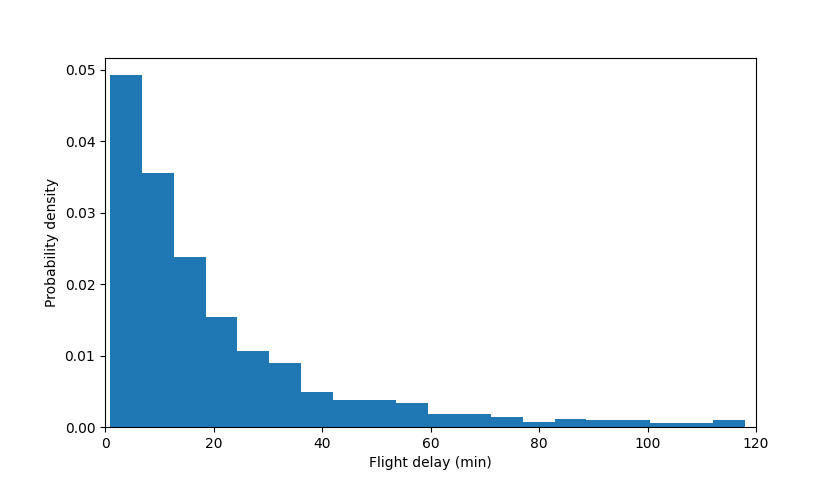

In [3]:
%matplotlib widget
import matplotlib.pyplot as plt

plt.figure(figsize=(8.4, 4.8))
_ = plt.hist(subdata.ARRIVAL_DELAY, log=False, bins=20, density=True)
plt.xlim(0, 120)
plt.xlabel('Flight delay (min)')
plt.ylabel('Probability density')
plt.show()

Remember the exponential distribution:

$f_X(x) = \lambda \exp(-\lambda x), x\geq 0$


In [4]:
from ipywidgets import widgets, interactive_output



class QuickWidget:
    def __init__(self, plot_func, title='', figsize=(8.4, 4.8)):
        self.plot_func = plot_func
        self.figure = plt.figure(figsize=figsize)
        self.ax = self.figure.add_subplot()
        self.title = title
        self.sliders = dict()

    def add_slider(self, min:float, max:float, value: float, step, param_name:str, param_description:str):
        slider = widgets.FloatSlider(description=param_description,
                                     min=min, max=max,
                                     value=value,
                                     step=step)
        self.sliders[param_name] = slider

    def set_xlim(self, *value):
        self.xlim = value

    def set_ylim(self, *value):
        self.ylim = value
    
    def _make_plot(self, *args, **kwargs):
        self.ax.clear()
        self.plot_func(self.ax, **kwargs)
        self.ax.set_xlim(*self.xlim)
        self.ax.set_ylim(*self.ylim)
        self.ax.set_ylabel(self.ylabel)
        self.ax.set_xlabel(self.xlabel)
        self.ax.set_title(self.title)
        
    def __call__(self):
        out = widgets.interactive_output(self._make_plot, self.sliders)
        return widgets.HBox([out, widgets.VBox(list(self.sliders.values()))])


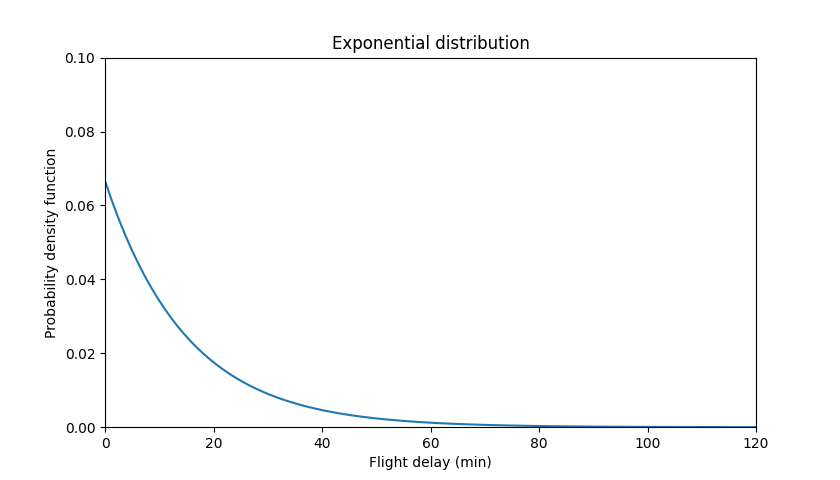

In [5]:
%matplotlib widget

import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import expon

def plot_func1(ax, lambd):
    dist = expon(scale = 1 / lambd)
    xs = np.linspace(0, 120, 100)
    ys = dist.pdf(xs)
    ax.plot(xs, ys)

widget = QuickWidget(plot_func1, title='Exponential distribution')
widget.set_xlim(0, 120)
widget.set_ylim(0, 0.1)
widget.xlabel = 'Flight delay (min)'
widget.ylabel = 'Probability density function'
widget.add_slider(1 / 100, 1 / 10, 1 / 15, 0.01, 'lambd', 'lambda')
widget()

An exponential distribution is a reasonable choice for the modelling of flight delays. However, if we want to make predictions of flight delays, we need to infer the value of $\lambda$ that best matches our data. Let's look at this in a qualitative way first.

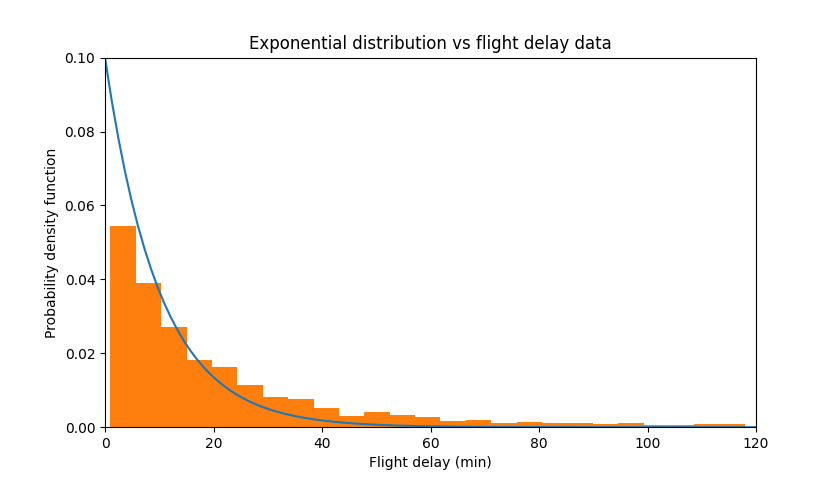

In [6]:
%matplotlib widget

import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import expon

def plot_func(ax, lambd):
    dist = expon(scale = 1 / lambd)
    xs = np.linspace(0, 120, 100)
    ys = dist.pdf(xs)
    ax.plot(xs, ys)
    ax.hist(subdata.ARRIVAL_DELAY, bins=25, density=True)

widget = QuickWidget(plot_func, title='Exponential distribution vs flight delay data')
widget.set_xlim(0, 120)
widget.set_ylim(0, 0.1)
widget.xlabel = 'Flight delay (min)'
widget.ylabel = 'Probability density function'
widget.add_slider(1 / 100, 1 / 10, 1 / 10, 0.01, 'lambd', 'lambda')
widget()

Our first objective is to fit our model to the data. Here what this means is finding the value of $\lambda$ that best matches the dataset.
We are going to investigate two standard approaches for this type of problem.

In [22]:
child1 = widgets.HTMLMath(value='<p>The method of moments is a simple method that matches theoretical and sample moments.</p>')
child2 = widgets.HTMLMath(value='<p>The method of Maximum Likelihood estimation relies on the likelihood function.</p>')

tab = widgets.Tab()
tab.children = [child1, child2]
tab.titles = ['Method of Moments', 'Method of Likelihood estimation']
tab

## Method of moments

Remember, in our previous example, having assumed that flight delays follow an exponential distribution, we wish to infer the parameter value $\lambda$ from the dataset.

The method of moments is a rather simple approach to this inference problem. The basic idea is as follows:
1. Obtain the sample mean of the data
2. Find the parameter value $\lambda$ such that the expectation is equal to the sample mean in 1.

### Sample mean

The sample mean is just what you might also know as the average. If we denote our random sample $X_1, \ldots, X_n$, then the sample mean is simply,

\begin{equation}
\overline{X} = \frac{1}{n}\sum_{i=1}^n{X_i}.
\end{equation}

In Python, we can use the numpy.mean command, as follows to compute it for our data.

In [27]:
xbar = np.mean(subdata.ARRIVAL_DELAY)
print(xbar)

20.36813808715337


### Mean function

We define the mean function as $\mu(\lambda) = E_{\lambda}[X]$, where $E_{\lambda}$ is the expectation but where we make the dependance on the parameter $\lambda$ explicit.
In more details,
\begin{equation}
    E_{\lambda}[X] = \int_{-\infty}^{\infty}{x f_X(x;\lambda)dx} = \int_{0}^{\infty}{x \lambda \exp(-\lambda x)dx}.
\end{equation}

We previously derived the expectation of the exponential distribution and had found that,

\begin{equation}
    \mu(\lambda) = \frac{1}{\lambda}.
\end{equation}

The Method of Moment estimator $\widehat{\lambda}$ is obtained by solving (in $\widehat{\lambda}$),

\begin{equation}
    \mu(\widehat{\lambda}) = \overline{X}. 
\end{equation}

Hence we simply get, in this case, 

\begin{equation}
    \widehat{\lambda} = \frac{1}{\overline{X}}.
\end{equation}

Now based on this, we can answer questions like the following: 

1. What is the probability that a flight has a delay greater than one hour?
2. Assume we offer a flight insurance where we pay 50 pounds back for a flight delay greater than one hour. What is the equilibrium price we should sell our insurance for?
3. Assume we offer a flight insurance where we pay 1 pound per minute of delay. What is the equilibrium price we should sell our insurance for?
4. Assume we offer a flight insurance where we pay back $x^{1.1}$ pounds back for a delay of $x$ minutes. What is the equilibrium price?

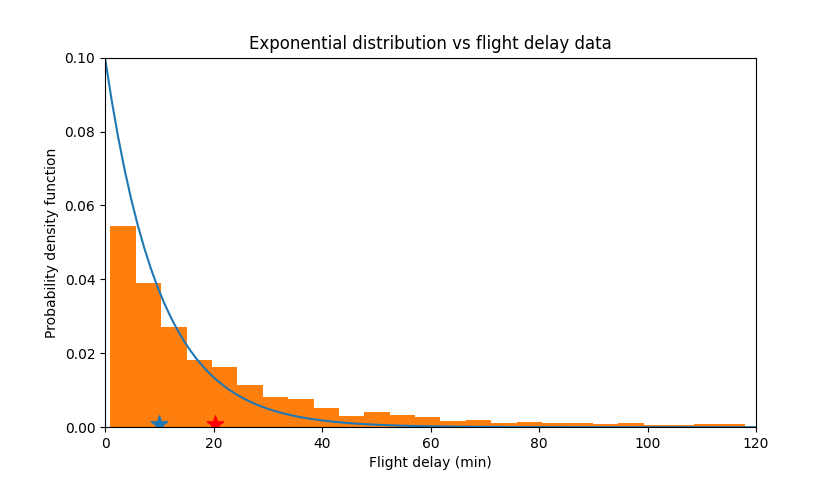

In [20]:
%matplotlib widget

import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import expon

def plot_func(ax, lambd):
    ax.clear()
    dist = expon(scale = 1 / lambd)
    xs = np.linspace(0, 120, 100)
    ys = dist.pdf(xs)
    ax.plot(xs, ys)
    ax.hist(subdata.ARRIVAL_DELAY, bins=25, density=True)
    ax.scatter(1 / lambd, 0.001, s=155, marker='*')
    ax.scatter(np.mean(subdata.ARRIVAL_DELAY), 0.001, s=155, c='red', marker='*')

widget = QuickWidget(plot_func, title='Exponential distribution vs flight delay data')
widget.set_xlim(0, 120)
widget.set_ylim(0, 0.1)
widget.xlabel = 'Flight delay (min)'
widget.ylabel = 'Probability density function'
widget.add_slider(1 / 100, 1 / 10, 1 / 10, 0.01, 'lambd', 'lambda')
widget()

## Likelihood estimation

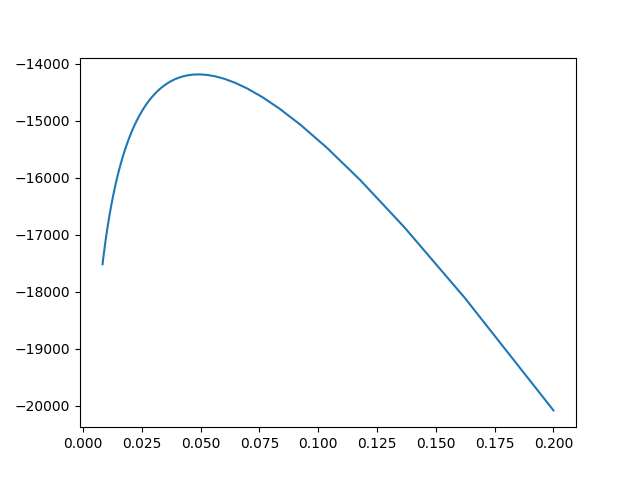

In [51]:
def plot_func(ax):
    ax.clear()
    xs = np.linspace(5, 120, 100).reshape((1, -1))
    ys = expon.pdf(xs)
    ax.plot(1 / xs.flatten(), np.sum(expon.logpdf(x=subdata.ARRIVAL_DELAY.to_numpy().reshape((-1, 1)), loc=np.zeros_like(xs), scale=xs), axis=0))

fig = plt.figure()
ax = fig.add_subplot()
plot_func(ax)